<a href="https://colab.research.google.com/github/guilherminog/tcc_timeseries/blob/main/Walmart_forecast_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Vendas de Lojas do Walmart

## Instalação de bilbiotecas

## Importação das bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from warnings import filterwarnings

import tensorflow as tf, keras
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import Adam

# Remover warnings
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
plt.figure(figsize=(16,10))

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

## Leitura dos dados

In [ ]:
url = "https://raw.githubusercontent.com/guilherminog/tcc_timeseries/refs/heads/main/dataset/Walmart.csv"

df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Modelo LSTM

### Carregado um  novo dataframe

In [ ]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


## Lojas

Nós precisamos adaptar o dataset para cada loja. O timeseries recebido pelo LSTM precisa conter uma continuidade clara e consisa.
Se utilizarmos o dataset contendo todo o histórico de vendas de todas as lojas, o modelo LSTM não conseguirá aprender a sazonalidade de cada loja individualmente, e a ordem da sazonalidade confundirá.

Podemos também realizar uma abordagem de juntar as lojas num unico dataframe, utilizando dados agregados de todas as lojas e fazendo média/soma nos valores quando apropriado apra agregá-los.  
As lojas possuem vários outros fatores que envolvem suas vendas, como localização, tamanho, concorrência local, performance de funcionários, disposição dos itens etc.  
Portanto parece mais apropriado que o modelo LSTM aprenda sobre a loja para uma previsão mais precisa.  
  
Nosso dataset possui  6435 semanas e 45 lojas, o que deixaria o treino do modelo preditivo para cada loja com poucos dados de treinamento, já que temos apenas dados de 143 semanas para cada loja.  
Desta forma, se escolhermos 70% do tamanho do nosso dataset, teremos approx 100 semanas para treino, o que é um número muito pequeno para um modelo LSTM e provavelmente não teríamos bons resultados.

Se optarmos pela abordagem de juntar todas as lojas e agregar seus valores, não teremos uma diferença no tamanho do dataset e ficaremos com o mesmo número de treino.  
Para sermos capazes de treinar um modelo LSTM de forma que nos aproveitemos de todas as lojas para o treino e do maior numero de dados possíveis, precisamos buscar uma abordagem diferente.

Entender a sazonalidade dos dados é a tarefa principal do nosso LSTM. Por ser multivariado, podemos treinar o modelo a detectar a magnitude da sazonalidade pelas features.
Para conter o maior número de dados possíveis, abriremos mão de precisão entre lojas, e criaremos um modelo único que servirá para qualquer loja. Algumas apresentarão resultados melhores que outras, mas o modelo será capaz de prever vendas de qualquer loja.
Vamos seguir com esta estratégia, mas clusterizar as lojas primeiro e executar um diferente fit para cada cluster pode se provar mais apropriado.  

In [ ]:
stores_count = df['Store'].nunique()
print(f'Total de lojas: {stores_count}')
print(f'Total de semanas: {len(df)}')
print(f'Total de semanas para cada loja: {len(df) / stores_count}')

Total de lojas: 45
Total de semanas: 6435
Total de semanas para cada loja: 143.0


## Corte de datas e divisão dos dados de treino e teste
Vamos separar pelo menos 1 ano para dados de treino, e manter o restante para teste.

Nosso dataset começa em fevereiro, então pode ser uma boa ideia avançar um pouco mais garantirmos que temos um ano completo de dados.   

O superbowl é em fevereiro, o dia do trabalho em setembro, ação de graças em novembro e natal em dezembro.  
Se usarmos um ano a partir de fevereiro, vamos ter o superbowl duas vezes, mas todos os outros feriados apenas uma vez.   
Para compensar um pouco e ajudar a dispersar o erro que o superbowl vai causar, podemos adicionar mais algumas semanas no nosso treino, evitando a páscoa para não repetirmos o problema.

Aproveito para deixar algumas variáveis aqui também a fim de facilitar ajustes finos de acordo com resultados obtidos.

In [ ]:
epochs=100
activation_model='tanh'
new_scaler = StandardScaler

target = 'Weekly_Sales'
variables = [target,] + ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

first_date = df['Date'].min()
last_date = df['Date'].max()
total_weeks = (last_date - first_date).days / 7
weeks_in_year = 365 // 7
total_weeks_train_cutoff = weeks_in_year + 8
total_weeks_train = total_weeks_train_cutoff - 1

end_train_date = first_date + pd.DateOffset(weeks=total_weeks_train_cutoff)

df_train = df[df['Date'] < end_train_date]
df_test = df[df['Date'] >= end_train_date]

print(f'Primeira data: {first_date}')
print(f'Última data: {last_date}')
print(f'Total de semanas: {total_weeks}')
print(f'Total de semanas num ano: {weeks_in_year}')
print(f'Data de corte escolhida: {end_train_date}')
print(f'\nTotal semanas de treino : {len(df_train)}')
print(f'Total semanas de teste: {len(df_test)}')

Primeira data: 2010-02-05 00:00:00
Última data: 2012-10-26 00:00:00
Total de semanas: 142.0
Total de semanas num ano: 52
Data de corte escolhida: 2011-04-01 00:00:00

Total semanas de treino : 2700
Total semanas de teste: 3735


# Definindo formato dos testes e resultados
Essa é talvez a tarefa mais importante do forecast por LSTM.  
O formato dos dados dirá ao modelo como ele efetivamente deve se comportar em seu treino, tal como também define o formato do nosso input para obter previsões futuras.

Como previamente decidimos que o modelo irá usar um número N de semanas para se basear, precisamos então treiná-lo com este mesmo número de semanas por vez.
Podemos então montar um input com formato (lojas, N, features) para treinar o modelo. Desta forma, teremos 48 treinos (numero de lojas) com N semanas de dados.

Logo, para obter uma previsão num cenário de uso real do modelo, precisamos pedir ao usuário que diga-nos todas as informações das últimas N semanas que aconteceram para que seja possível prever qual será a Weekly_Sales da próxima. Veremos isto durante o predict em breve.

Nosso output Y é a Weekly_Sales da próxima semana, já que gostaríamos de prever somente Weekly_Sales e mais nenhum valor, o formato de Y será (lojas, 1).

### Primeiro, separamos o X_train e o Y_train
Nosso y_train terá a previsão que o LSTM "deveria" ter feito da loja para ser capaz de ser treinado.

Será a semana seguinte à última semana de cada loja que usaremos para treino.  
Para isso, removemos do df_train a ultima semana de cada loja e separamos em um segundo dataframe.

Note que o tamanho de y_train é o número de lojas, e o tamanho de x_train é o número de lojas * numero de semanas de treino

In [ ]:
last_week_for_y_train = df_train['Date'].max()

y_train = df_train[df_train['Date'] >= last_week_for_y_train]
x_train = df_train[df_train['Date'] < last_week_for_y_train]

print(f"len(y_train) = lojas? {len(y_train) == stores_count}")
print(f"len(x_train) = lojas * semanas treino? {len(x_train) == stores_count * total_weeks_train}")
print(f"Total de lojas para treino foi distibuído corretamente? {len(x_train) + len(y_train) == len(df_train)}")

print(f"\nshape x_train: {x_train.shape}")
print(f"shape y_train: {y_train.shape}")

len(y_train) = lojas? True
len(x_train) = lojas * semanas treino? True
Total de lojas para treino foi distibuído corretamente? True

shape x_train: (2655, 8)
shape y_train: (45, 8)


### Deixando os dataframes somente com as variaveis que iremos usar

In [ ]:
x_train_shaped = x_train.sort_values(['Store', 'Date'], ascending=[True, True])[variables]
y_train_shaped = y_train.sort_values(['Store', 'Date'], ascending=[True, True])[variables]

print(f"shape x_train: {x_train_shaped.shape}")
print(f"shape y_train: {y_train_shaped.shape}")

shape x_train: (2655, 6)
shape y_train: (45, 6)


### Aplicando a normalização
As funções de ativação tahn e sigmoid são sensíveis à magnitude dos dados, então é uma boa ideia aplicarmos um scaler para normalizar os dados.  
new_scaler fica como variáveil para facilitar ajustes finos futuros.

O scaler precisa de todos os dados par normalizar corretamente, incluindo nossa coluna Y. Portanto, vamos juntar as duas depois separamos novamente.  
Não podemos fazer isto antes porque precisamos da coluna Date pra separar X_train e Y_train, e nossas variáveis não contam com ela.  
 Logo, se aplicarmos o scaler antes, perdemos os dados e também erramos na normalização.

In [ ]:
scaler = new_scaler()
df_to_scale = pd.concat([x_train_shaped, y_train_shaped], ignore_index=True)
df_scaled = scaler.fit_transform(df_to_scale)

y_train_scaled = df_scaled[len(x_train):]
x_train_scaled = df_scaled[:len(x_train)]

print(f"shape x_train: {x_train_scaled.shape}")
print(f"shape y_train: {y_train_scaled.shape}")

shape x_train: (2655, 6)
shape y_train: (45, 6)


### Aplicando o formato
Não conseguimos usar nossas funções de um dataframe comum aqui pois passamos a ter dados normalizados.  
Felizmente, ordenamos anteriormente, então podemos usufruir da ordem para montar o formato que queremos (lojas, semanas_treino, n_variaveis)  
Digamos que semanas_treino = 10. Se obtermos os 10 primeiros itens de x_train_scaled, este será todos os dados de treino da loja 1.  

In [ ]:
x_train_aux = []
for i in range (1, stores_count+1):
    x_train_aux.append(x_train_scaled[(i-1) * total_weeks_train:i * total_weeks_train])

# target é a primeira variável, definimos anteriormente a ordem das colunas no script
# então podemos usar a ordem para manipular a y_train
y_train_aux = []
for i in range (0, len(y_train_scaled)):
    y_train_aux.append(y_train_scaled[i][0])

x_train_final, y_train_final = np.array(x_train_aux), np.array(y_train_aux)

print(f"x_train_final shape {x_train_final.shape}")
print(f"y_train_final shape {y_train_final.shape}")

x_train_final shape (45, 59, 6)
y_train_final shape (45,)


## Definindo o modelo

In [ ]:
model = keras.models.Sequential()

model.add(LSTM(64, activation=activation_model, input_shape=(x_train_final.shape[1], x_train_final.shape[2]), return_sequences=True,))
model.add(LSTM(32, activation=activation_model, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 59, 64)              │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

### Fitting

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.6305 - val_loss: 0.0645
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0426 - val_loss: 0.0327
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0108 - val_loss: 0.0265
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0087 - val_loss: 0.0152
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0053 - val_loss: 0.0108
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0077 - val_loss: 0.0146
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0050 - val_loss: 0.0162
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0065 - val_loss: 0.0126
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0083 - val_loss: 0.0191
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0186 - val_loss: 0.0145
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

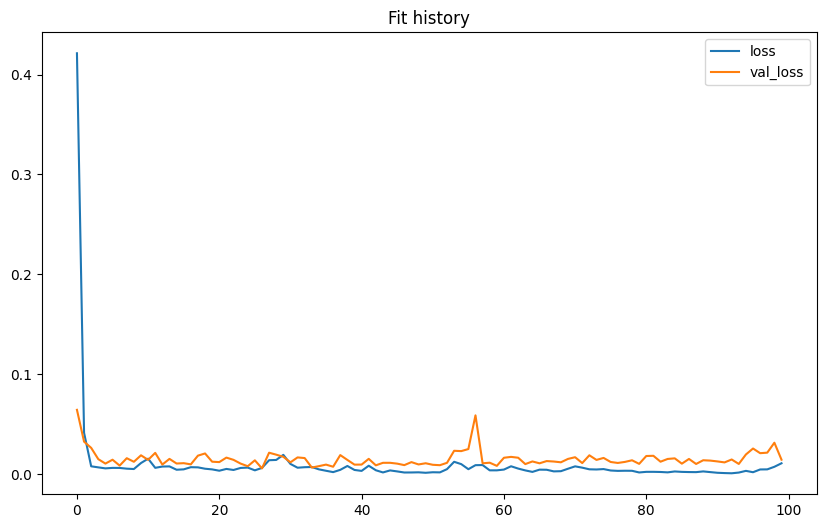

In [ ]:
history = model.fit(x_train_final, y_train_final, epochs=epochs, batch_size=1, validation_split=0.1, verbose=1)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Fit history')
plt.legend()
plt.show()

In [ ]:
# para fazer o forecast precisamos agora trabalhar com todos os dados que não trabalhamos antes quando separamos dataframes de treino e teste.
# vamos fazer o mesmo processo de normalização e formatação para os dados de teste.
# depois desnormalizamos para comparar.


# precisamos de 59 semanas anteriores para prever a próxima.
# vamos fazer isso várias vezes para uma loja apenas para visualizarmos como fica, depois executamos para todas lojas.

def predict_for_store(store_number):
    df_store_test = df_test[df_test['Store'] == store_number].sort_values(['Date'], ascending=[True])
    df_store_complete = df[df['Store'] == store_number].sort_values(['Date'], ascending=[True])
    y_test = df_store_test[target]
    x_test = []

    for _, row in df_store_test.iterrows():
        # busca itens anterioes ao atual de df_store_test
        # adiciona o resultado ao final de x_test
        past_weeks = df_store_complete[df_store_complete['Date'] < row['Date']].tail(total_weeks_train)
        normalized = scaler.transform(past_weeks[variables])
        x_test.append(normalized)

    x_test = np.array(x_test)
    y_pred = model.predict(x_test)

    # para conserguirmos desnormalizar, precisamos que o nosso y_pred esteja no mesmo formato que o scaler teve o fit.
    # vamos transformar  o y_pred só para atender o tamanho correto do scaler
    y_pred = np.repeat(y_pred, len(variables), axis=1)
    y_pred = scaler.inverse_transform(y_pred)[:,0]
    return y_pred, y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


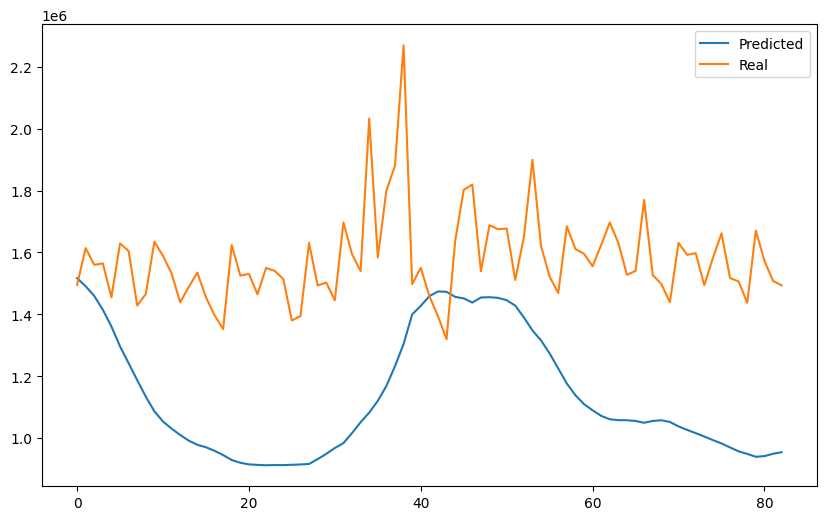

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


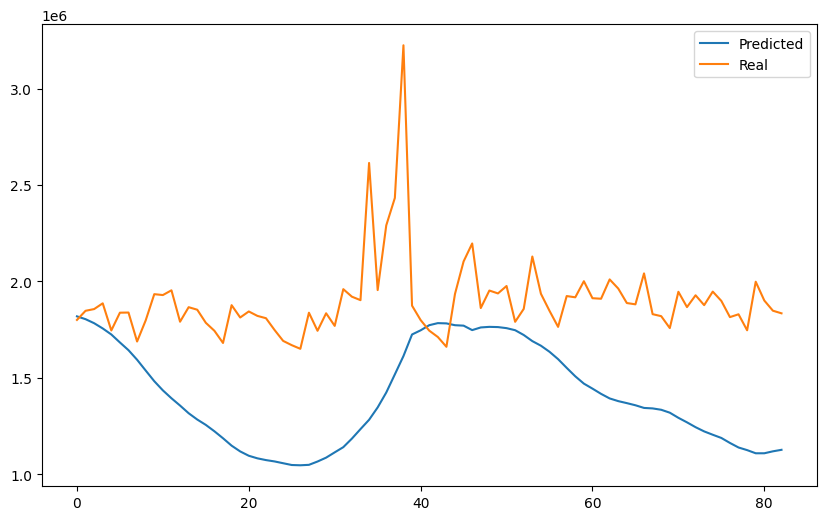

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


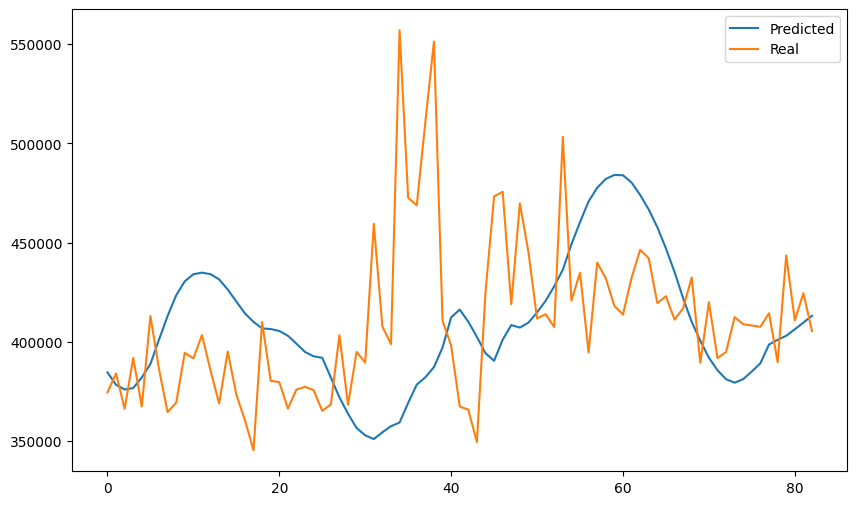

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


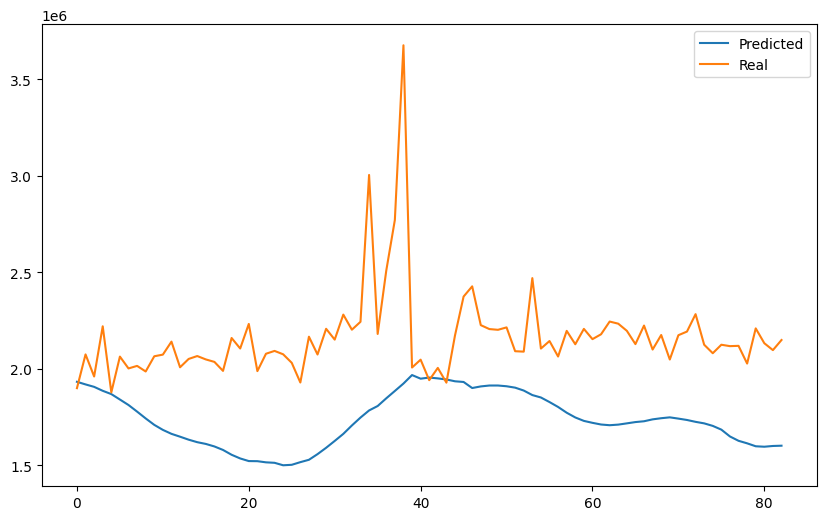

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


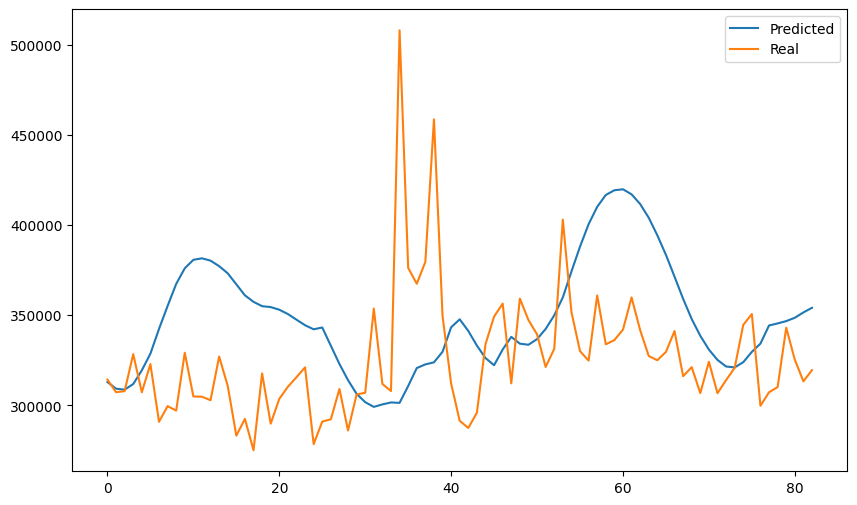

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


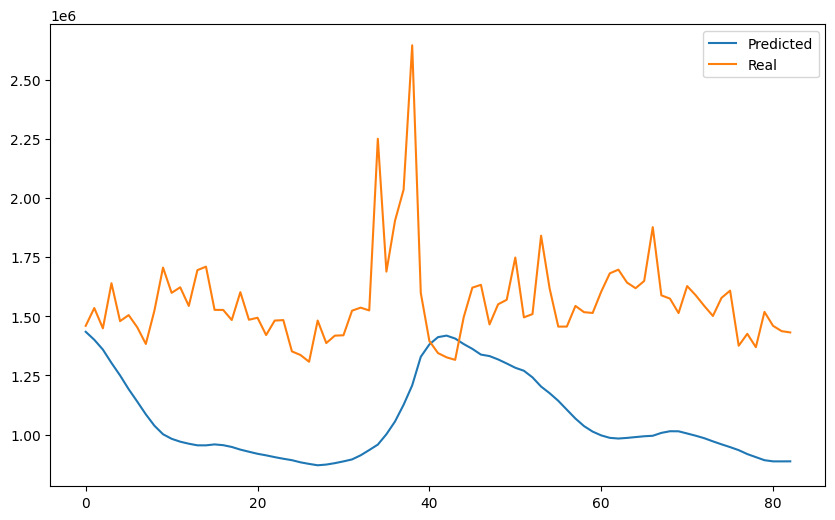

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


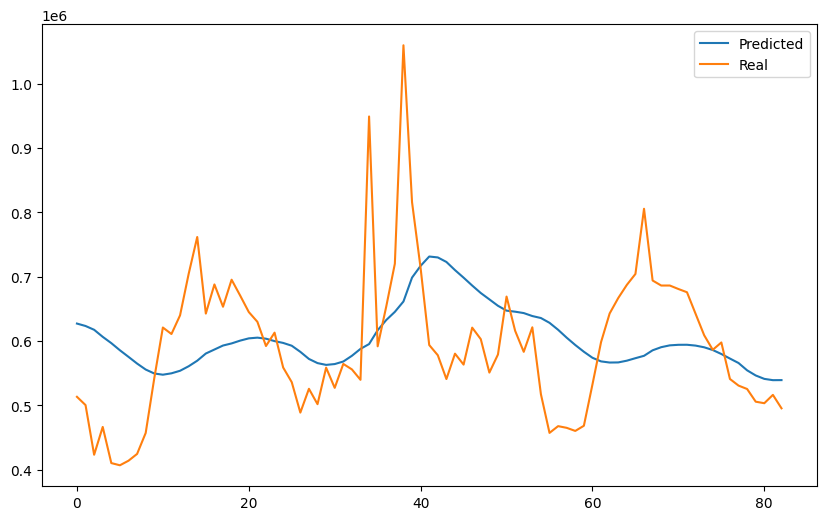

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


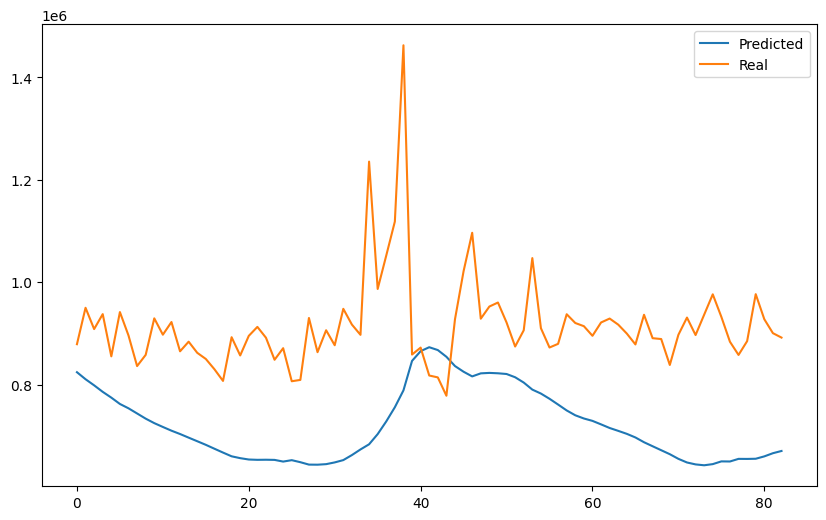

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


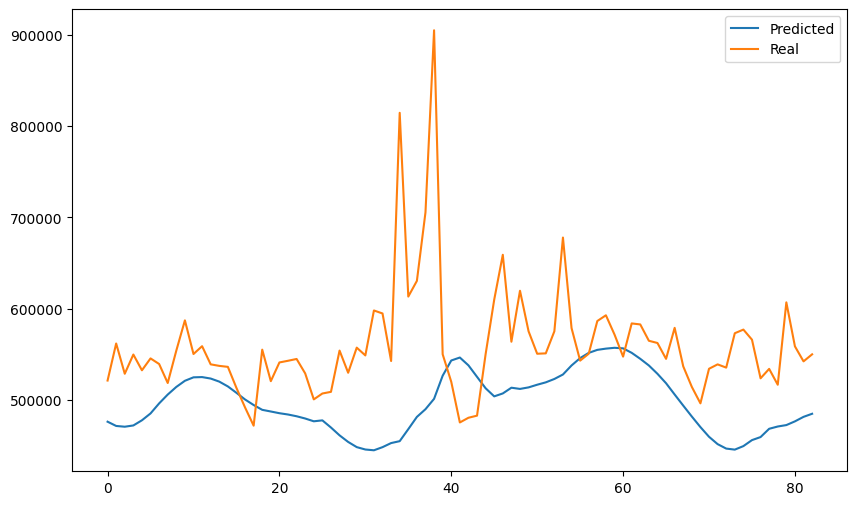

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


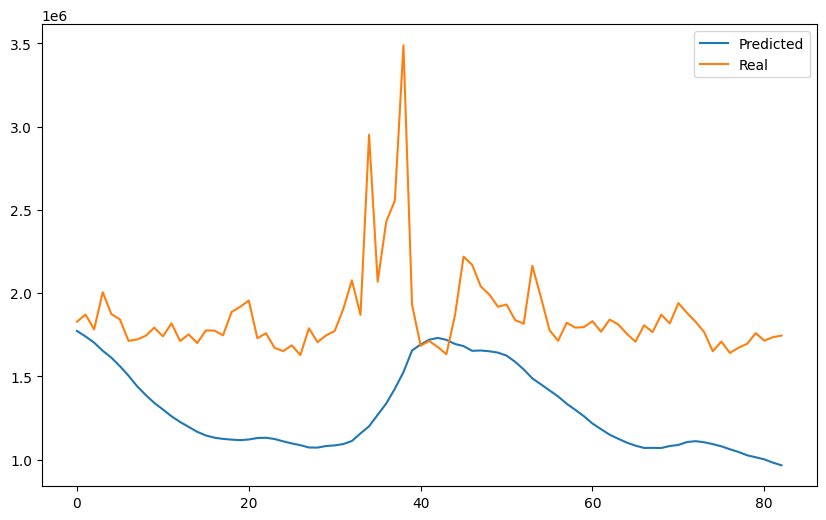

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


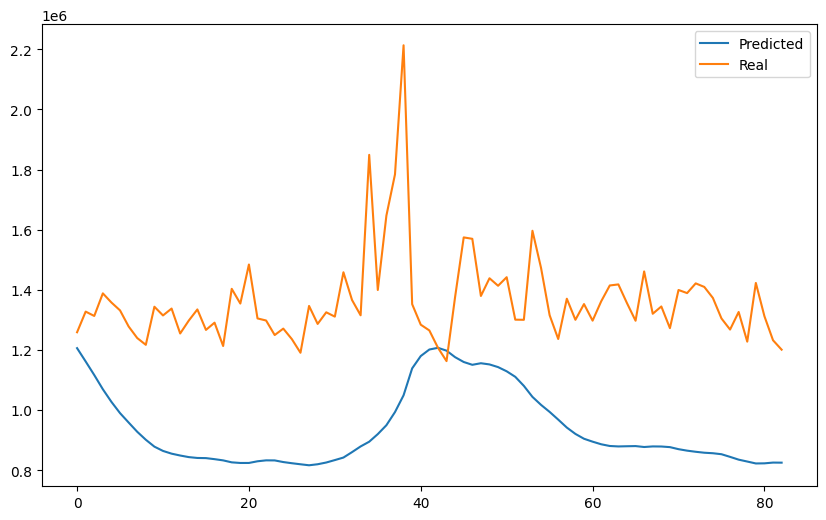

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


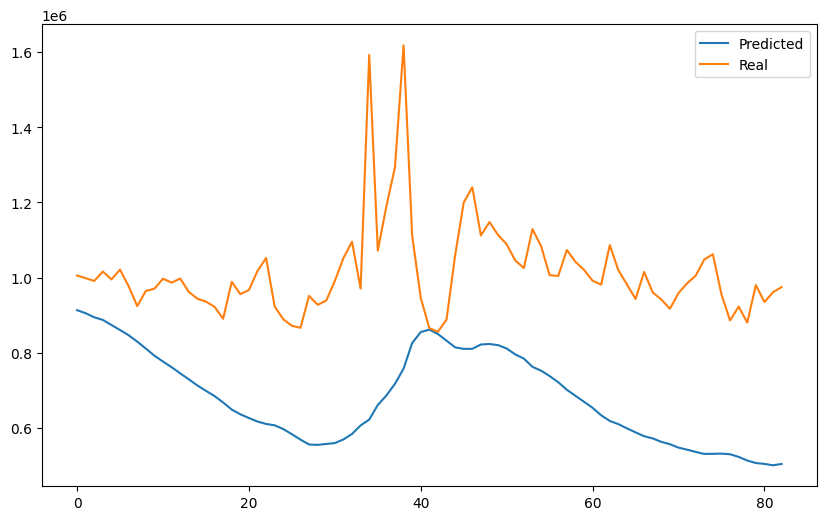

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


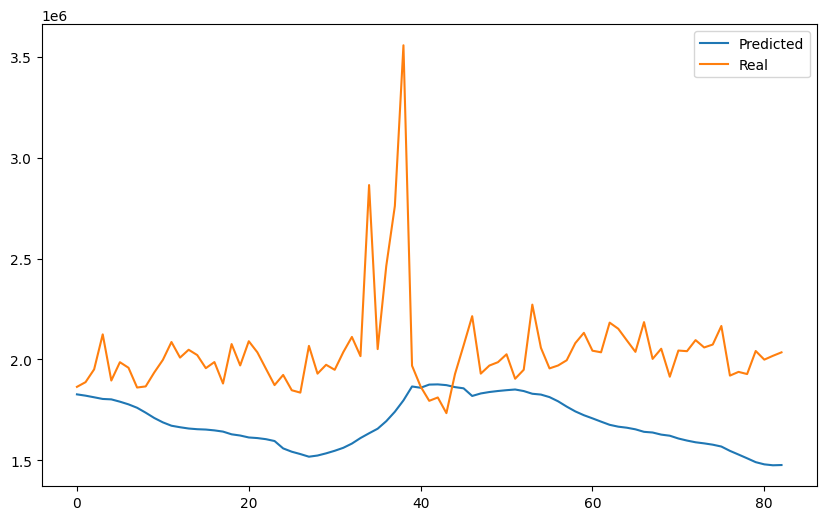

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


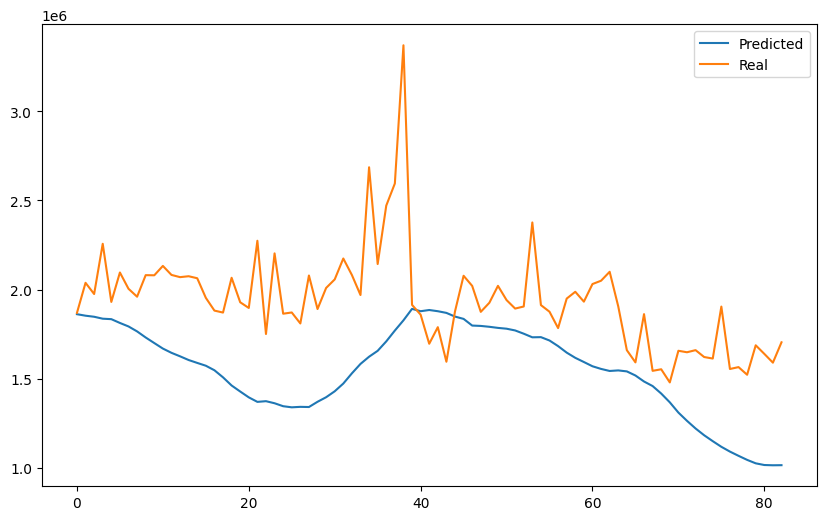

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


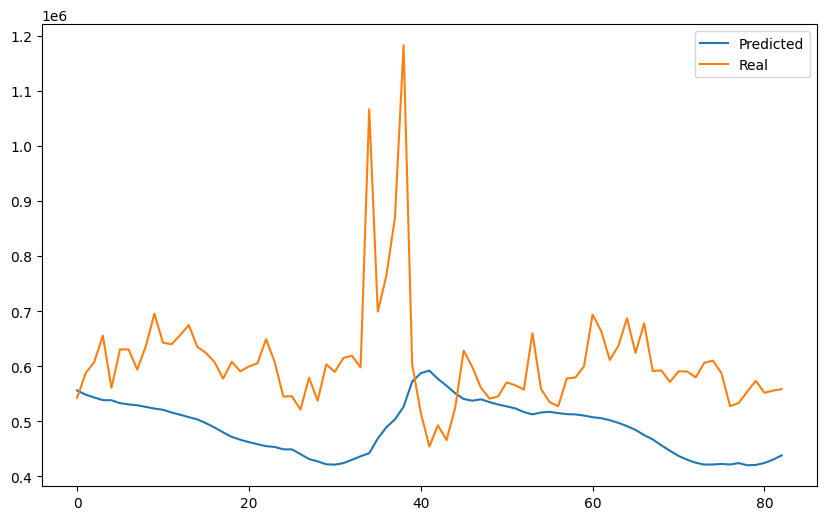

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


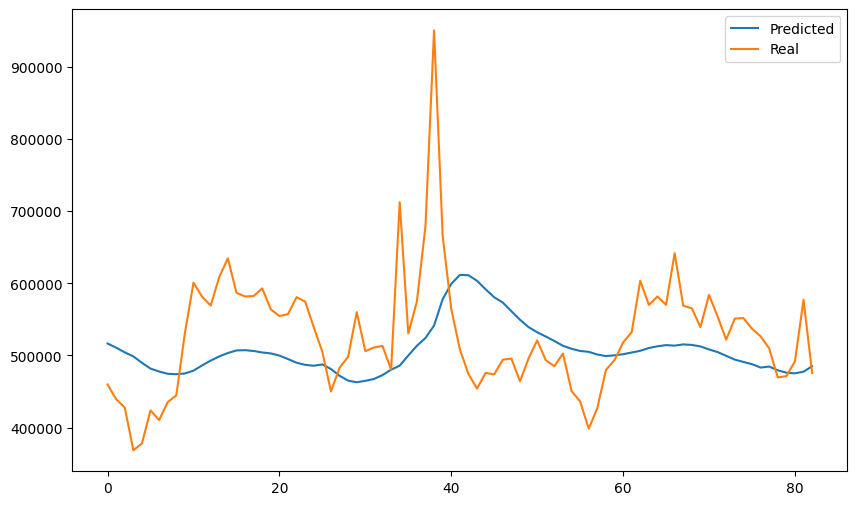

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


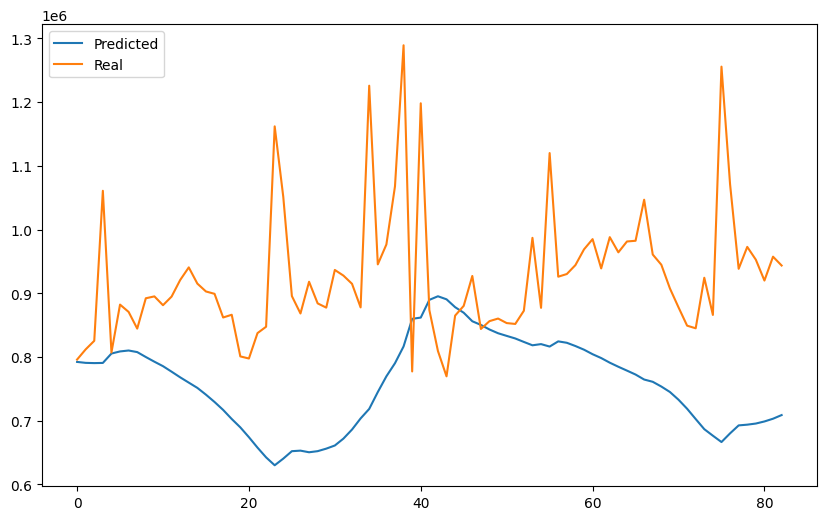

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


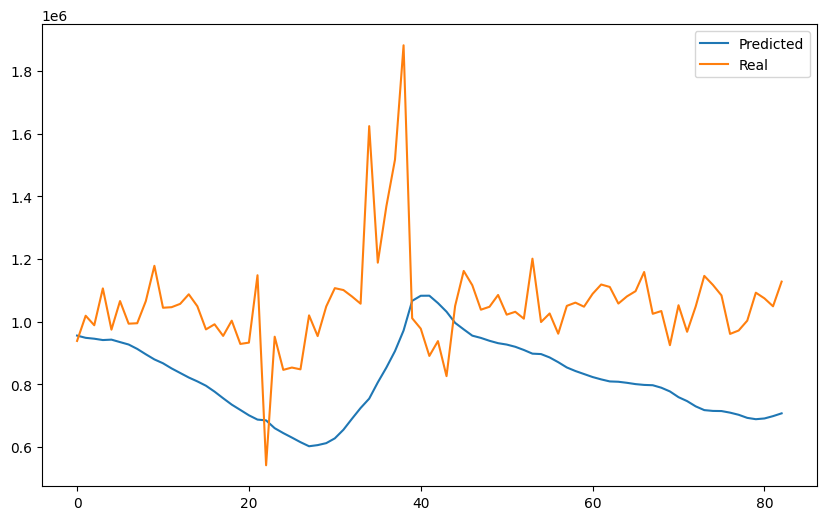

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


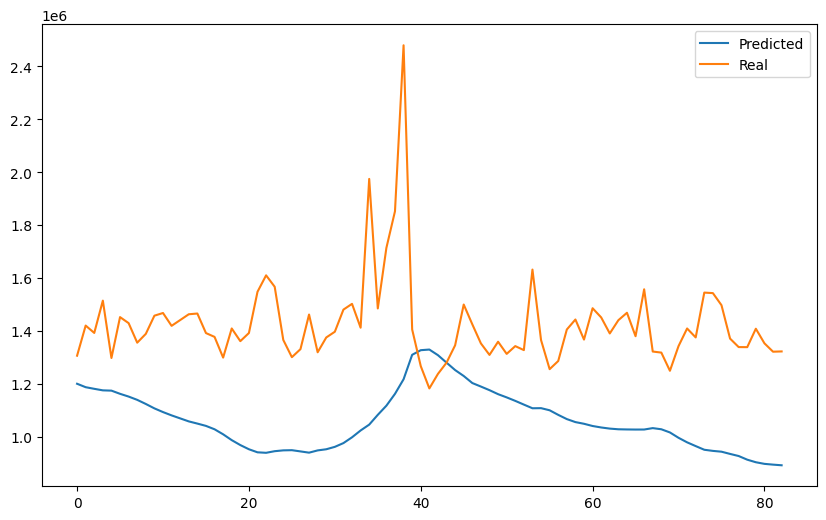

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


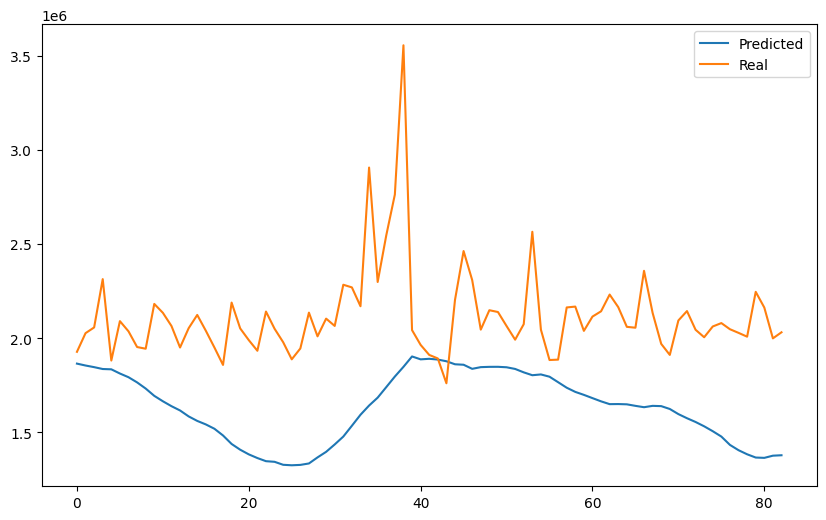

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


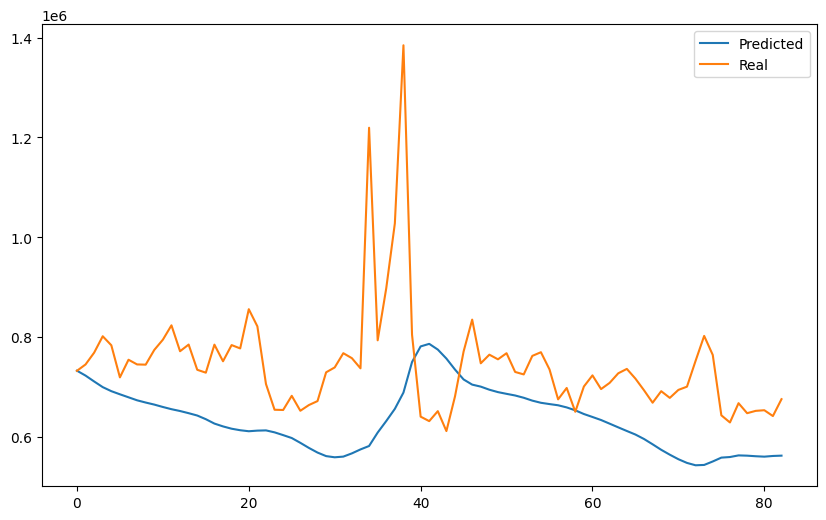

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


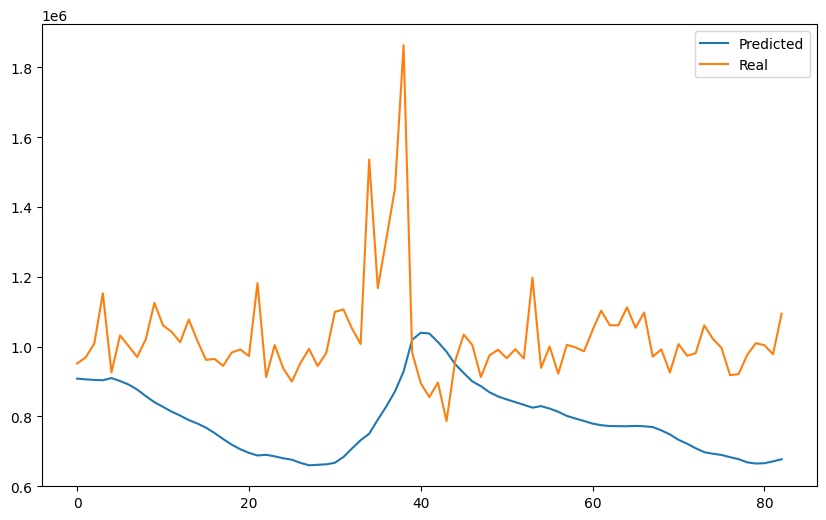

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


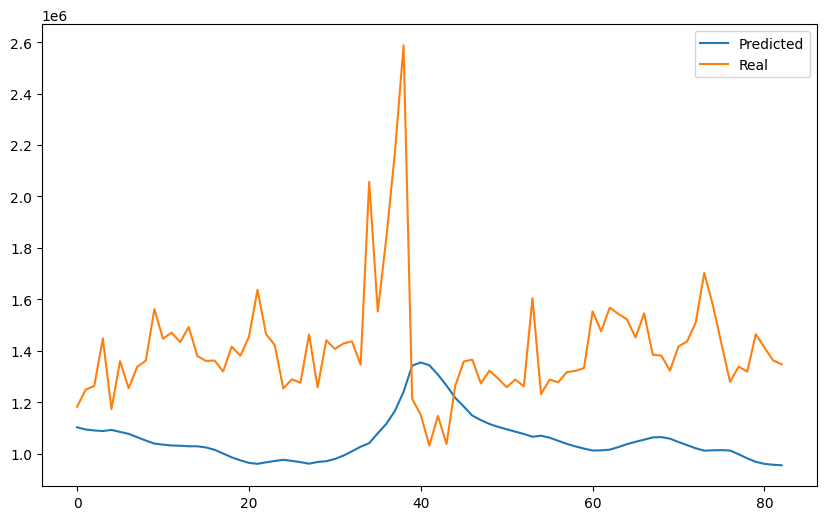

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


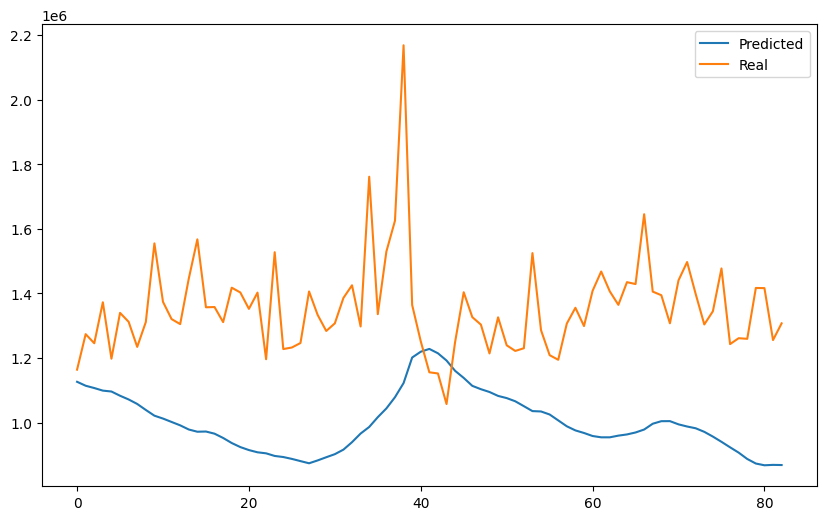

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


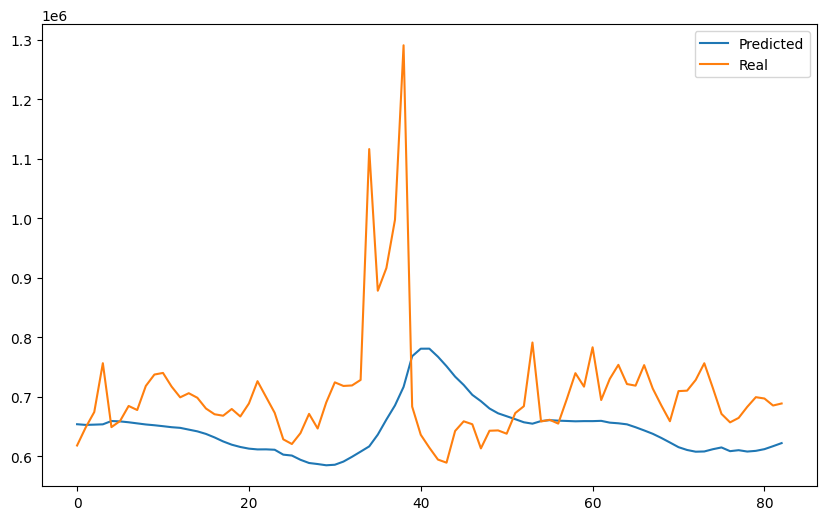

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


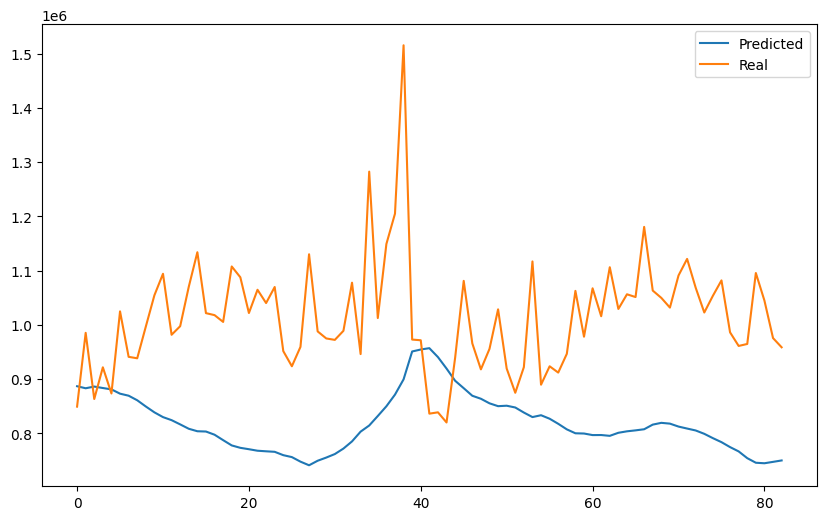

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


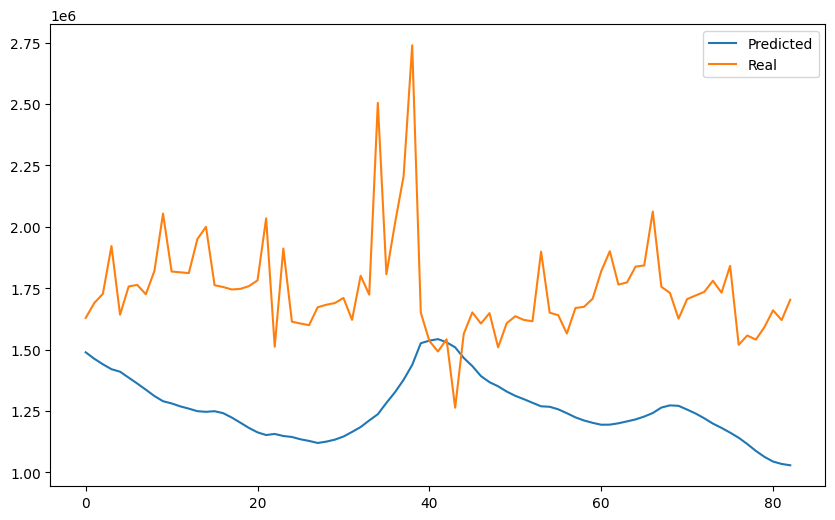

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


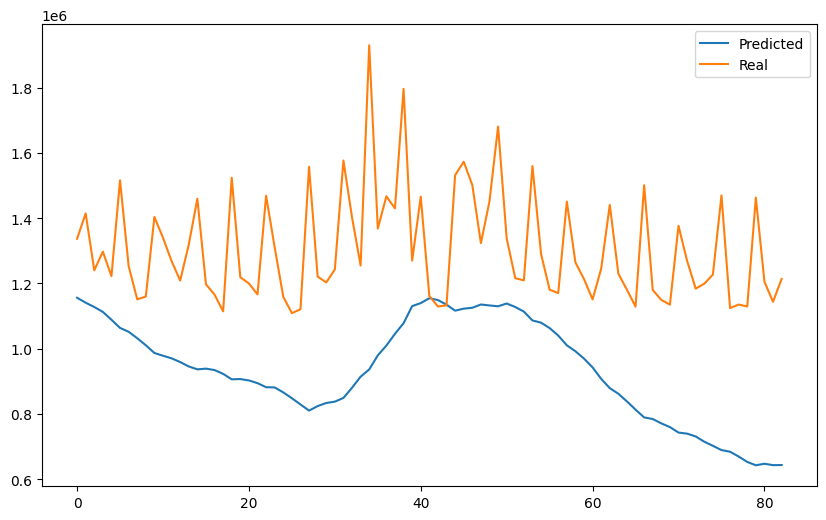

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


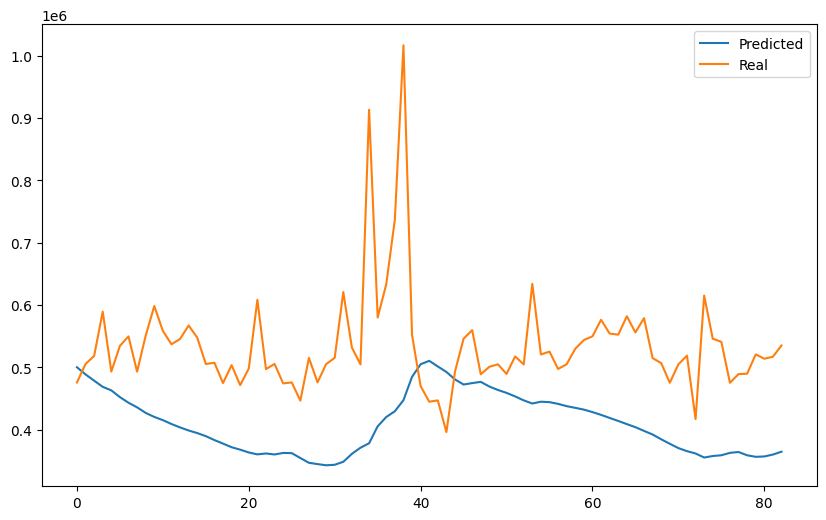

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


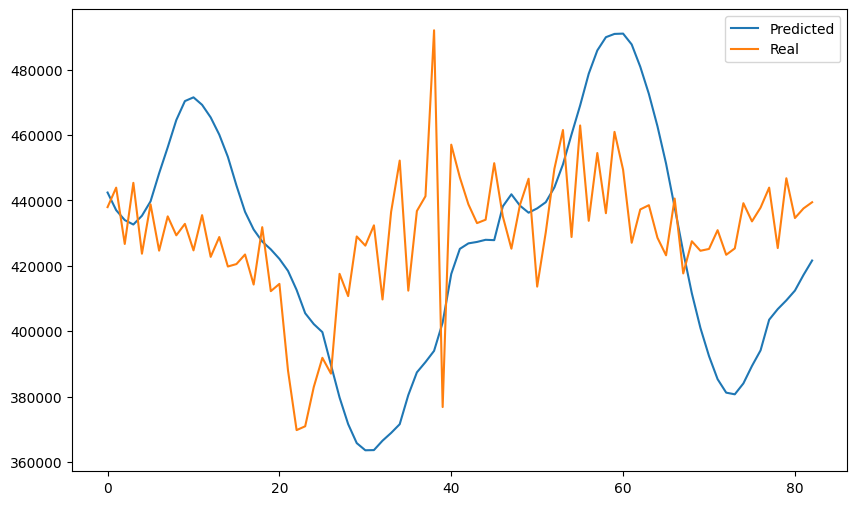

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


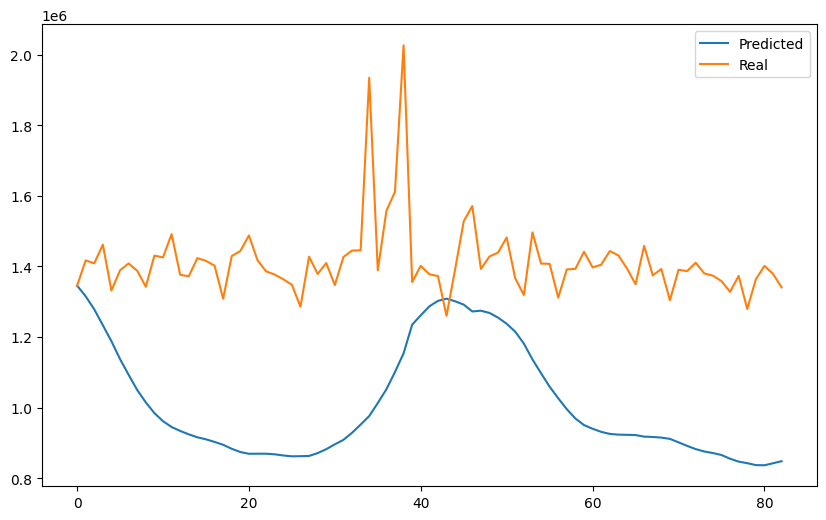

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


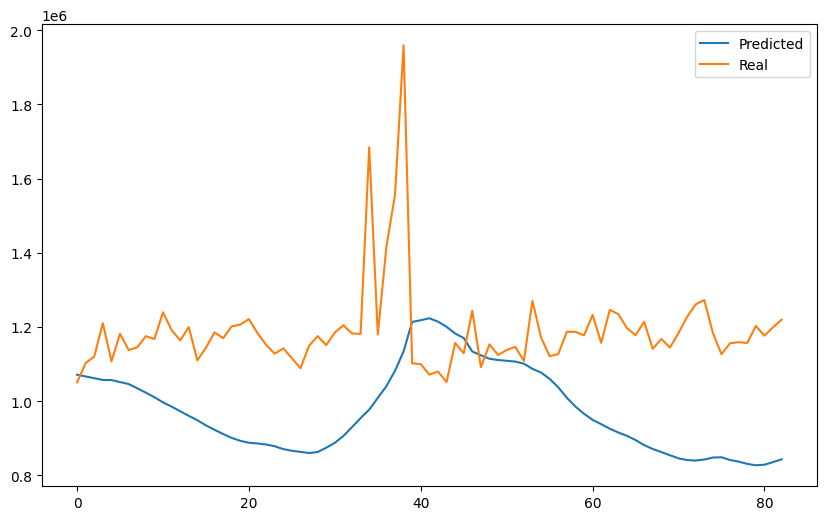

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


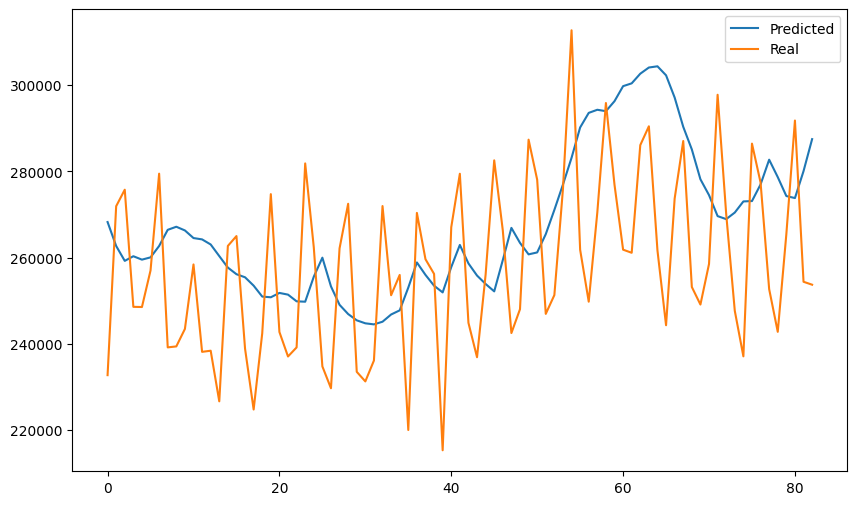

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


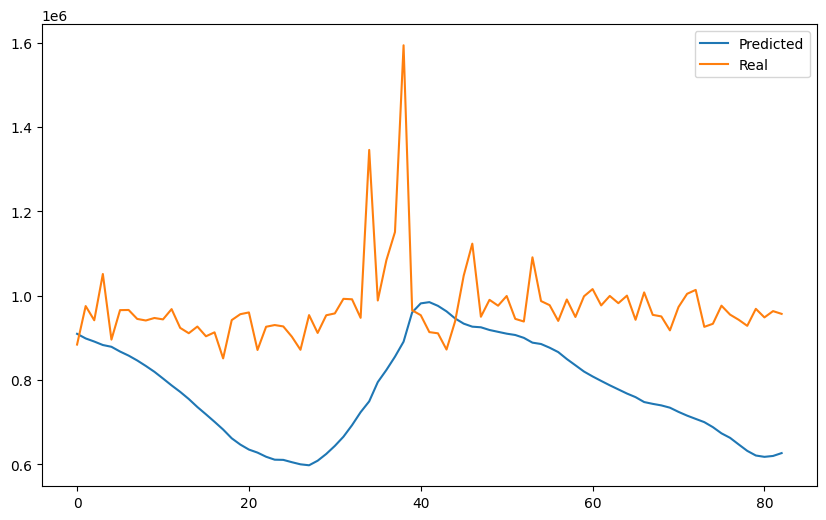

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


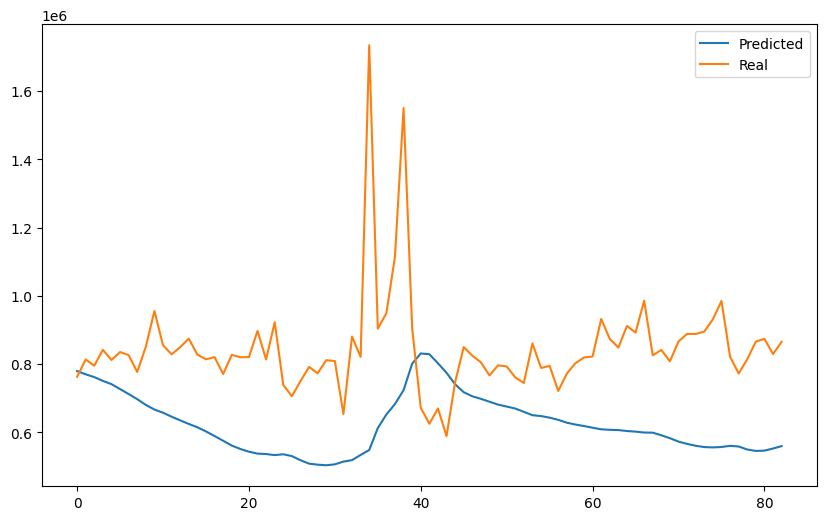

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


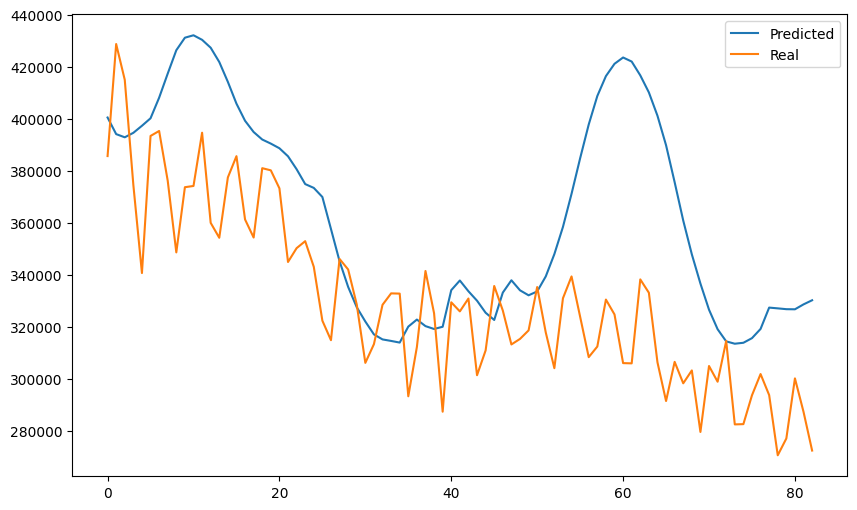

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


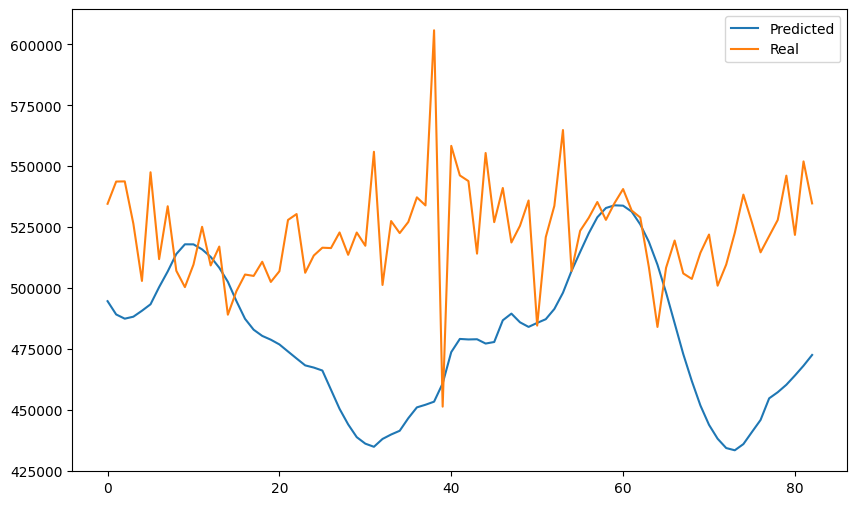

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


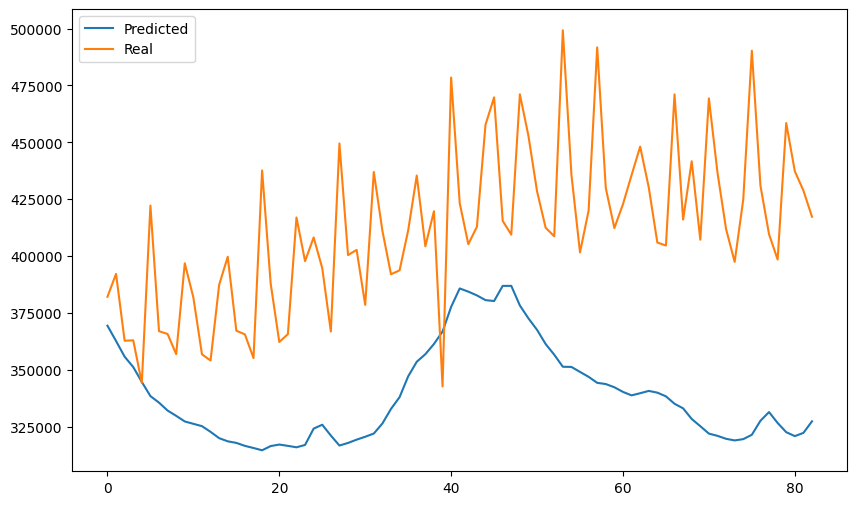

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


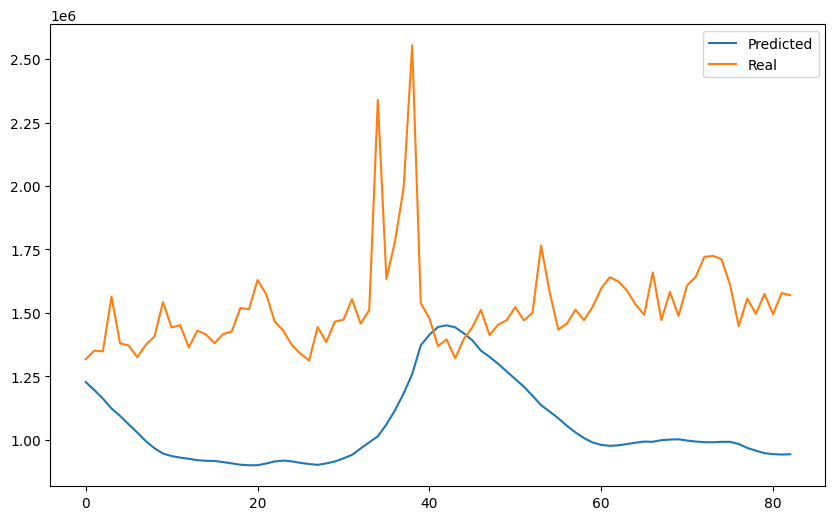

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


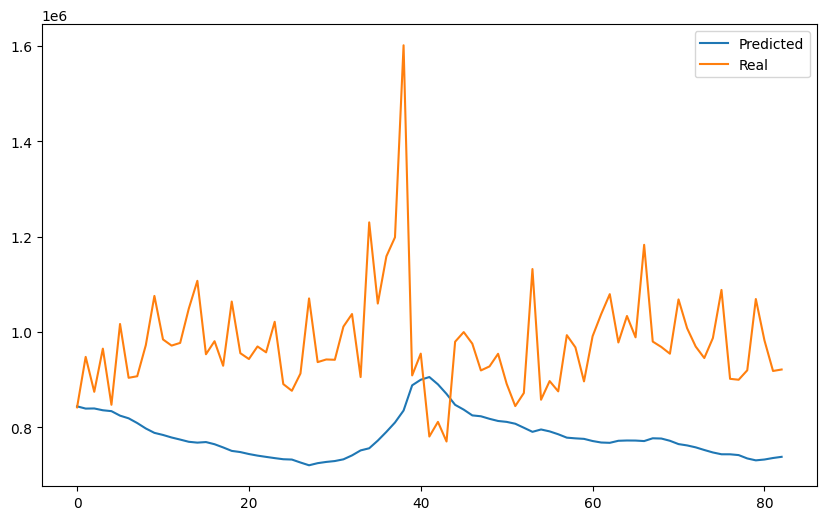

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


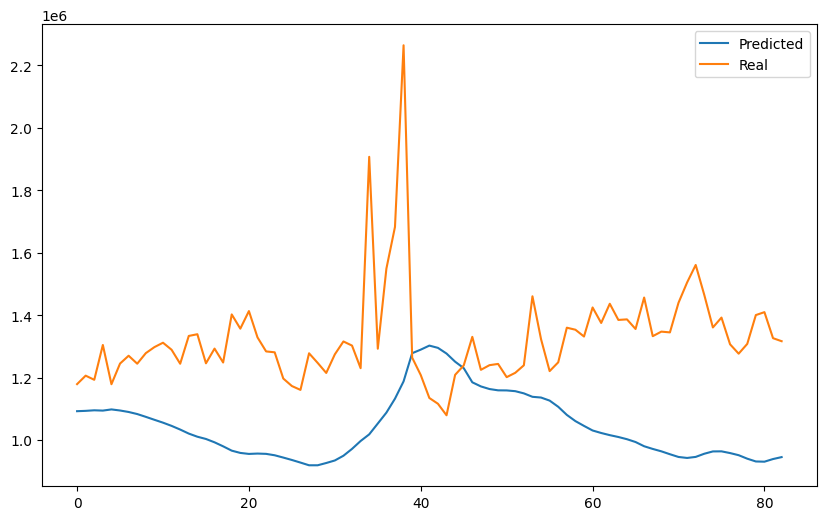

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


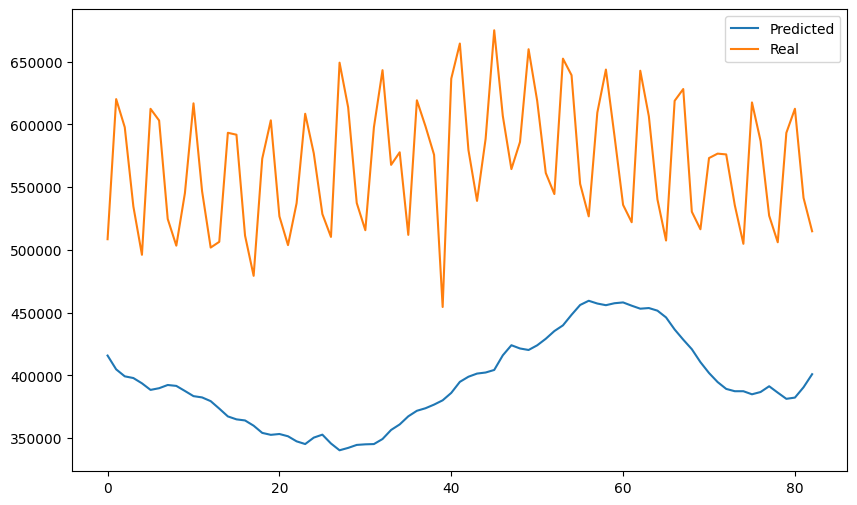

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


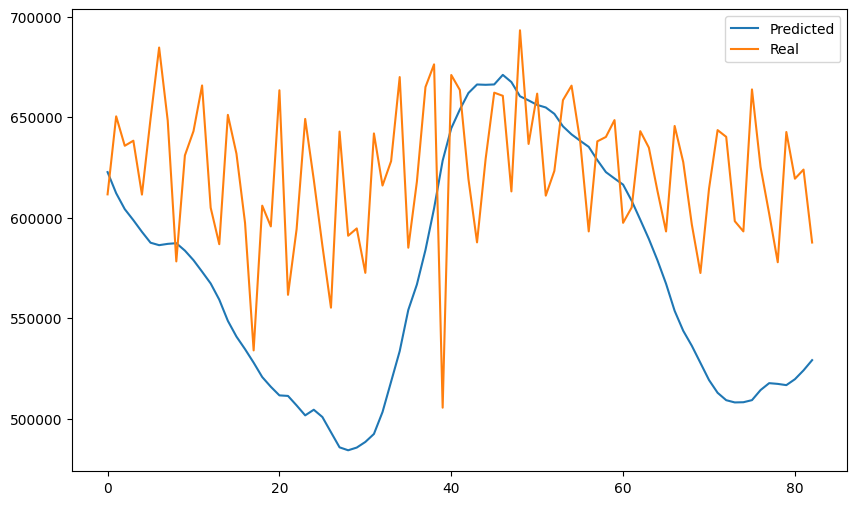

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


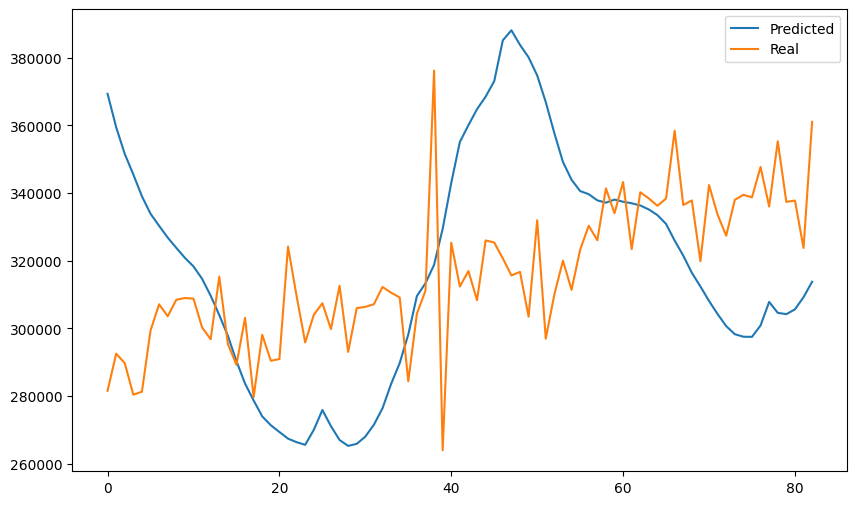

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


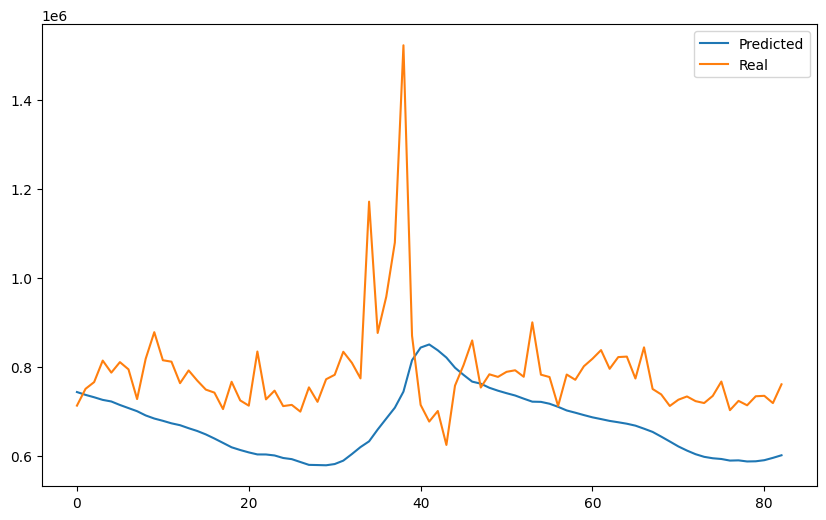

In [ ]:
for i in range(1, stores_count+1):
    y_pred, y_test = predict_for_store(i)

    plt.figure(figsize=(10, 6))
    plt.plot(y_pred, label='Predicted')
    plt.plot(y_test.values, label='Real')
    plt.legend()
    plt.show()